In [10]:
# sam2 video segmentation test

import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import numpy as np
import torch
import matplotlib.pyplot as plt
from sam2.build_sam import build_sam2_video_predictor
from PIL import Image

# select the device for computation
#if torch.cuda.is_available():
    #device = torch.device("cuda")
#elif torch.backends.mps.is_available():
    #device = torch.device("mps")
#else:
device = torch.device("cpu")

In [11]:
# model location
sam_loc = '/home/ganidhu/sam2'
sam2_checkpoint = f'{sam_loc}/checkpoints/sam2.1_hiera_large.pt'
model_cfg = f'configs/sam2.1/sam2.1_hiera_l.yaml'

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [12]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

In [13]:
video_dir = 'data/video/bottle_falling'

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
# frame_idx = 0
# plt.figure(figsize=(9, 6))
# plt.title(f"frame {frame_idx}")
# plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|██████████| 314/314 [00:13<00:00, 22.79it/s]


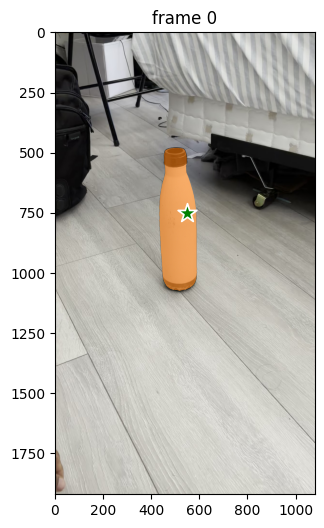

In [15]:
input_points = np.array([[550, 750]], dtype=np.float32)
input_labels = np.array([1])

#inference_state = predictor.init_state(video_path=video_dir)

ann_frame_idx = 0 # the frame where the input point is being registered
ann_obj_id = 1 # an identifier for the 'selected' object.
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=input_points,
    labels=input_labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(input_points, input_labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

#plt.savefig(f"test.png")

In [9]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)



propagate in video:   0%|          | 1/314 [00:00<00:05, 53.49it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 144.00 MiB. GPU 0 has a total capacity of 5.68 GiB of which 51.12 MiB is free. Including non-PyTorch memory, this process has 5.54 GiB memory in use. Of the allocated memory 5.15 GiB is allocated by PyTorch, and 252.18 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)